In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [19]:
!python -V

Python 3.7.11


In [20]:
df = pd.read_parquet('green_tripdata_2022-01.parquet', engine='pyarrow')

In [21]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62495 entries, 0 to 62494
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               62495 non-null  int64         
 1   lpep_pickup_datetime   62495 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  62495 non-null  datetime64[ns]
 3   store_and_fwd_flag     56200 non-null  object        
 4   RatecodeID             56200 non-null  float64       
 5   PULocationID           62495 non-null  int64         
 6   DOLocationID           62495 non-null  int64         
 7   passenger_count        56200 non-null  float64       
 8   trip_distance          62495 non-null  float64       
 9   fare_amount            62495 non-null  float64       
 10  extra                  62495 non-null  float64       
 11  mta_tax                62495 non-null  float64       
 12  tip_amount             62495 non-null  float64       
 13  t

In [23]:
df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).apply(lambda td: td.total_seconds()/60)

In [24]:
#df = df[df.trip_type == 2]

In [25]:
df.duration.describe()

count    62495.000000
mean        19.019387
std         78.215732
min          0.000000
25%          7.000000
50%         11.583333
75%         18.200000
max       1439.466667
Name: duration, dtype: float64

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

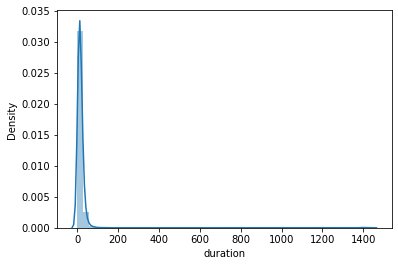

In [26]:
sns.distplot(df.duration)

In [27]:
print(f"The percentage of trips for 1 <= time <= 60 is: {((df.duration >= 1) & (df.duration <= 60)).mean()*100}%")
print(f"The percentage of trips for 0 <= time <= 60 is: {((df.duration >= 0) & (df.duration <= 60)).mean()*100}%")
df = df[(df.duration >= 1) & (df.duration <= 60)]

The percentage of trips for 1 <= time <= 60 is: 95.37242979438355%
The percentage of trips for 0 <= time <= 60 is: 98.68149451956157%


In [28]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]
#df_train = df[categorical + numerical]
#df_train.head()

In [29]:
dv = DictVectorizer()
df[categorical] = df[categorical].astype(str)
df_train = df[categorical + numerical].to_dict(orient = "records")

In [30]:
X_train = dv.fit_transform(df_train)
X_train

<59603x471 sparse matrix of type '<class 'numpy.float64'>'
	with 178809 stored elements in Compressed Sparse Row format>

In [31]:
target = 'duration'
y_train = df[target]

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


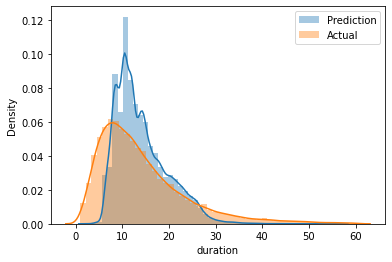

In [33]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label = 'Actual')
plt.legend()

In [34]:
mean_squared_error(y_train, y_pred, squared=False)

7.652810588274314